In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scipy.optimize as opt
import matplotlib.pyplot as graph

from tqdm import trange

sns.set(font_scale=1.2)

In [2]:
graph.style.use('fivethirtyeight')

## MLE

If you assume your data came from a normal distribution you can determine the parameters of that distribution given the data

This is done through likelihood calculations - a data point of 102 is more likely to be drawn from a normal distribution centered on 100 than a normal distribution centered on 0

Mean IQ: 99.81684084562633, Std IQ: 14.970100080770987


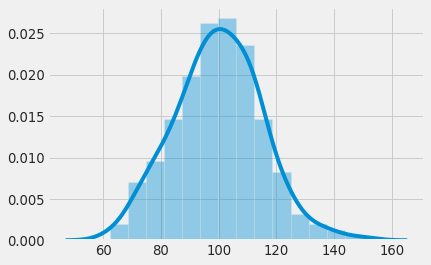

In [3]:
# Sampling data
iq = stats.norm(100, 15).rvs(250)
print(f'Mean IQ: {iq.mean()}, Std IQ: {iq.std()}')

sns.distplot(iq)
graph.show()

In [4]:
# Calculate likelihoods
iq_dist = stats.norm(100, 15)

iq_dist.pdf(160), np.prod(iq_dist.pdf([80, 100, 110]))

(8.922015050992357e-06, 6.193084361475613e-06)

In [5]:
# Given a mean and std calculate the likelihood of the data 
trace = []

def norm_loglikelihood(params):
    mu, sig = params
    trace.append(mu)
    return -stats.norm(mu, sig).logpdf(iq).sum()

print(f'Loglikelihood of data if mean 0 and std 1: {norm_loglikelihood([0, 1])}')
print(f'Loglikelihood of data if mean 100 and std 15: {norm_loglikelihood([100, 15])}')

Loglikelihood of data if mean 0 and std 1: 1273667.9362369755
Loglikelihood of data if mean 100 and std 15: 1031.2679856345708


In [6]:
# Minimize the loglikelihood using various means and stds
trace = []
opt.fmin(norm_loglikelihood, [0, 1], full_output=True)

Optimization terminated successfully.
         Current function value: 1031.248354
         Iterations: 107
         Function evaluations: 205


(array([99.81680124, 14.97011742]), 1031.2483542602365, 107, 205, 0)

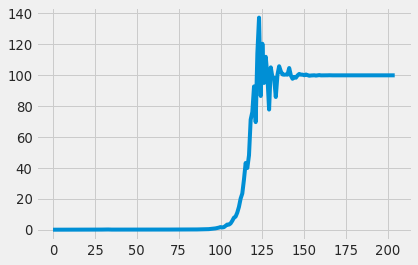

In [7]:
# Trace of the means
graph.plot(trace)
graph.show()

# GLM

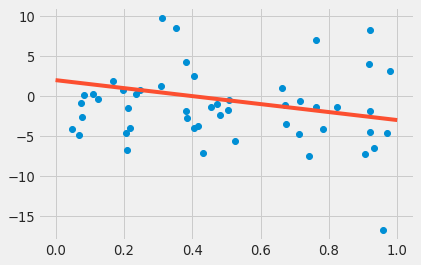

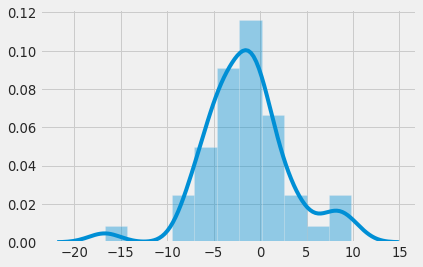

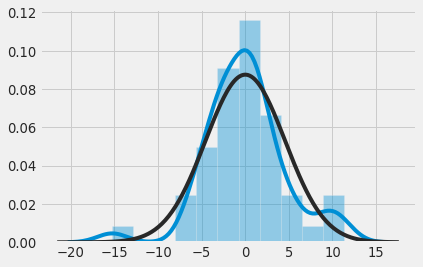

In [8]:
# Create data with slope -5 and intercept 2
m, b = -5, 2

x = stats.uniform().rvs(50)
y = m*x + b + stats.norm(0, 5).rvs(len(x))
xs = np.linspace(0, 1, 100)

graph.plot(x, y, 'o')
graph.plot(xs, m*xs + b)
graph.show()

sns.distplot(y)
graph.show()

sns.distplot(y - y.mean(), fit=stats.norm)
graph.show()

In [9]:
# Calculate loglikelihoods given m, b and std
def regression_loglike(param):
    mi, bi, sig = param
    trace.append([mi, bi])
    resid = y - (mi*x + bi)
    return -stats.norm(0, sig).logpdf(resid).sum()

print(regression_loglike([3, 3, 1]))
print(regression_loglike([-5, 2, 1]))

1497.5337275804177
599.2494246702009


Optimization terminated successfully.
         Current function value: 146.335171
         Iterations: 213
         Function evaluations: 384


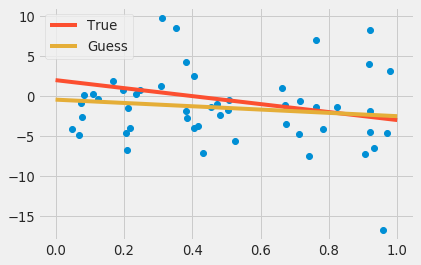

In [10]:
# Fit the data
trace = []
regression_params = opt.fmin(regression_loglike, [0, 0, 1])

graph.plot(x, y, 'o')
graph.plot(xs, m*xs + b, label='True')
graph.plot(xs, regression_params[0]*xs + regression_params[1], label='Guess')
graph.legend()
graph.show()

# P Values

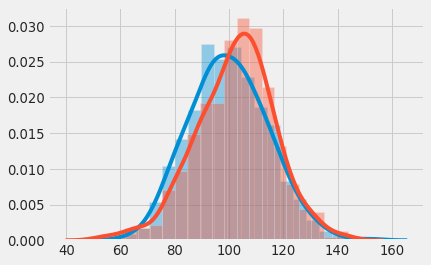

In [11]:
# Sample iq 
n = 500
girls, boys = stats.norm(100, 15).rvs(n), stats.norm(103, 15).rvs(n)

sns.distplot(girls)
sns.distplot(boys)
graph.show()

In [12]:
# Calculate test statistics 
def sm_stat(a, b):
    return a.mean() - b.mean()

test_stat = sm_stat(boys, girls)
print(f'Test stat: {test_stat}')

Test stat: 2.3225250566858193


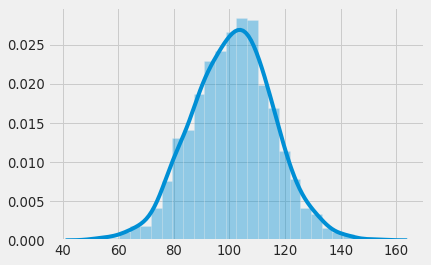

In [13]:
sns.distplot(np.hstack([girls, boys]))
graph.show()

In [14]:
# Get null distribution by randomly shuffling the labels
pool_dataset = np.hstack([girls, boys])
null_stats = []
for _ in trange(50000):
    shuffle = np.random.choice(pool_dataset, len(pool_dataset), replace=False)
    so_girl, so_boy = shuffle[:n], shuffle[n:]
    
    null_stats.append(sm_stat(so_boy, so_girl))
null_stats = np.array(null_stats)

100%|██████████| 50000/50000 [00:02<00:00, 24470.03it/s]


In [15]:
# Get alternate distribution using bootstrapping
alternate_stats = []
for _ in trange(50000):
    alternate_stats.append(sm_stat(np.random.choice(boys, len(boys)), np.random.choice(girls, len(girls))))
alternate_stats = np.array(alternate_stats)

100%|██████████| 50000/50000 [00:01<00:00, 33418.85it/s]


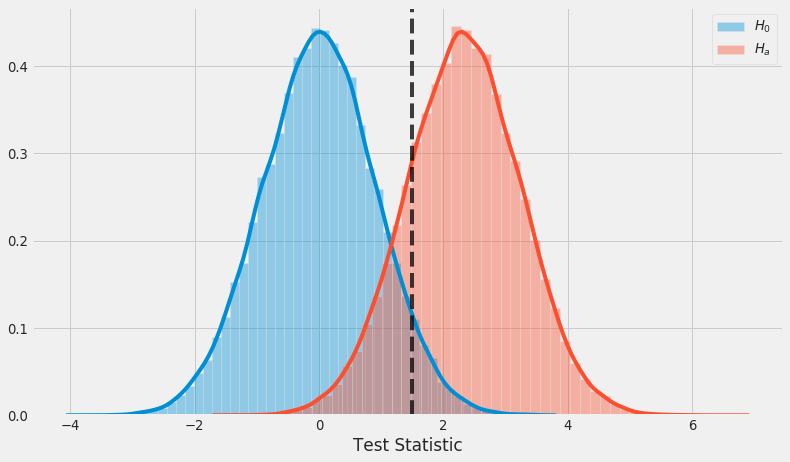

critical 1.495901102831967
p-value 0.00522
Power 0.8163
T-Test  0.011209674428033474


In [16]:
alpha = 95  # Percentage
critical_value = np.percentile(null_stats, alpha)

graph.figure(figsize=(12, 7))
sns.distplot(null_stats, label=r'$H_0$')
sns.distplot(alternate_stats, label=r'$H_a$')
graph.axvline(critical_value, color='black', alpha=0.75, linestyle='dashed')
graph.xlabel('Test Statistic')
graph.legend()
graph.show()

print('critical', critical_value)
print('p-value', (null_stats >= test_stat).mean())
print('Power', 1-(alternate_stats <= critical_value).mean())
print('T-Test ', stats.ttest_ind(girls, boys).pvalue)

The larger the area under the curve to the right of the critical value of the alternate distribution the more power you have to detect the effect given there is a true effect

# Multiple Test Correction

These corrections shift the critical value further to the right, which makes the test more conservative but prevents getting false positives

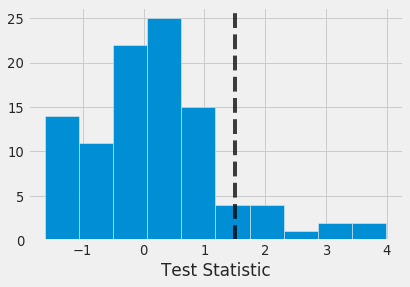

FP 3
TP 7


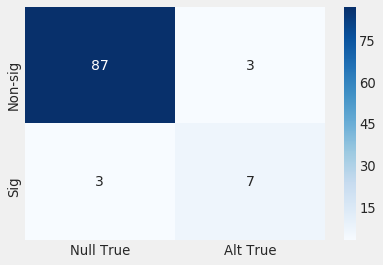

In [17]:
# 100 tests with a test statistic, 90 from the null distribution, 10 from the alternate
n_true = 10
n_null = 90

bad_tests = np.random.choice(null_stats, n_null)
good_tests = np.random.choice(alternate_stats, n_true)

all_test = np.append(bad_tests, good_tests)

graph.hist(all_test)
graph.axvline(critical_value, color='black', alpha=0.75, linestyle='dashed')
graph.xlabel('Test Statistic')
graph.show()

false_pos = (bad_tests > critical_value).sum()
true_pos = (good_tests > critical_value).sum()
false_neg = n_true - true_pos
true_neg = n_null - false_pos

print('FP', false_pos)
print('TP', true_pos)

confusion_matrix = np.array([
    [true_neg, false_neg], 
    [false_pos, true_pos],
])
confusion_matrix_df = pd.DataFrame(confusion_matrix, columns=['Null True', 'Alt True'], index=['Non-sig', 'Sig'])

sns.heatmap(confusion_matrix_df, annot=True, cmap='Blues')
graph.show()

2.9623636135678177
Power 0.24148000000000003


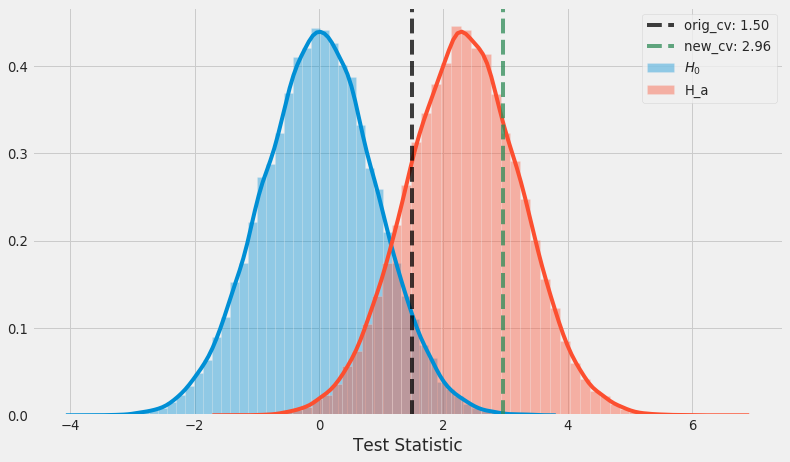

In [18]:
# Bonferroni correction
corrected_alpha = 0.05 / len(all_test)

corrected_critical_value = np.percentile(null_stats, 100 * (1 - corrected_alpha))
print(corrected_critical_value)
print('Power', 1-(alternate_stats <= corrected_critical_value).mean())

graph.figure(figsize=(12, 7))
sns.distplot(null_stats, label=r'$H_0$')
sns.distplot(alternate_stats, label=r'H_a')
graph.axvline(critical_value, color='black', label=f'orig_cv: {critical_value:.2f}', linestyle='dashed', alpha=0.75)
graph.axvline(corrected_critical_value, color='seagreen', label=f'new_cv: {corrected_critical_value:.2f}', linestyle='dashed', alpha=0.75)
graph.xlabel('Test Statistic')
graph.legend()
graph.show()

FP 0
TP 4


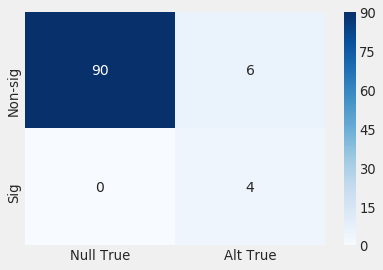

In [19]:
false_pos = (bad_tests > corrected_critical_value).sum()
true_pos = (good_tests > corrected_critical_value).sum()
false_neg = n_true - true_pos
true_neg = n_null - false_pos

print('FP', false_pos)
print('TP', true_pos)

confusion_matrix = np.array([
    [true_neg, false_neg], 
    [false_pos, true_pos],
])

confusion_matrix_df = pd.DataFrame(confusion_matrix, columns=['Null True', 'Alt True'], index=['Non-sig', 'Sig'])

sns.heatmap(confusion_matrix_df, annot=True, cmap='Blues')
graph.show()

Multiple testing correction shifts the critical value further to the right to be more conservative - this reduces the recall but avoids false positives